In [253]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns
import torch

EXPERIMENT_DIR = Path("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/K562_hvg_filter_none/chr19/model_training_001/")
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
GROUND_TRUTH_DIR = Path(PROJECT_DIR, "data/ground_truth_files")
OTHER_METHOD_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.GRN_BENCHMARKING.MOELLER/testing_bear_grn/INFERRED.GRNS")

dataset_type = "k562" #"mESC"
sample_name_list = ["K562"]

## Testing Gradient Attribution

### Functions

In [ ]:
def load_vocab(selected_experiment_dir):
    id2name = torch.load(selected_experiment_dir / "tf_tg_vocab_id2name.pt", map_location="cpu")
    tf_names = list(id2name["tf_id2name"])
    tg_names = list(id2name["tg_id2name"])

    return tf_names, tg_names

def load_ground_truth(ground_truth_file):
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep, on_bad_lines="skip", engine="python")
    
    if "chip" in ground_truth_file.name and "atlas" in ground_truth_file.name:
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
        
    return ground_truth_df

def prep_gt_edges(gt_df: pd.DataFrame) -> pd.DataFrame:
    gt = gt_df[["Source", "Target"]].dropna().copy()
    gt["Source"] = gt["Source"].astype(str).str.upper()
    gt["Target"] = gt["Target"].astype(str).str.upper()
    gt = gt.drop_duplicates()
    gt["_in_gt"] = 1
    return gt

def eval_method_vs_gt(method_df: pd.DataFrame, gt_edges: pd.DataFrame, top_fracs=(0.001, 0.005, 0.01, 0.05)):
    if method_df is None or len(method_df) == 0:
        # return NaNs but keep consistent columns
        out = {
            "auroc": np.nan, "auprc": np.nan, "pos_rate": np.nan, "lift_auprc": np.nan
        }
        for frac in top_fracs:
            out[f"precision@{frac*100:.2f}%"] = np.nan
            out[f"lift@{frac*100:.2f}%"] = np.nan
        return out

    # Merge GRN with ground truth to label edges
    d = method_df.merge(gt_edges, on=["Source", "Target"], how="left")
    y = d["_in_gt"].fillna(0).astype(int).to_numpy()
    s = d["Score"].to_numpy()

    # Calculate AUROC and AUPRC scores
    auroc = roc_auc_score(y, s) if np.unique(y).size == 2 else np.nan
    auprc = average_precision_score(y, s) if y.sum() > 0 else np.nan
    pos_rate = y.mean()

    # Pre-sort once for precision@K
    order = np.argsort(s)[::-1]
    y_sorted = y[order]
    tp = np.cumsum(y_sorted)
    k = np.arange(1, len(y_sorted) + 1)
    prec = tp / k

    # Calculate precision@K and lift@K for each K
    prec_at = {}
    for frac in top_fracs:
        K = int(frac * len(y_sorted))
        if K < 1:
            K = 1
        if K > len(prec):
            K = len(prec)
        prec_at[f"precision@{frac*100:.2f}%"] = float(prec[K-1]) if len(prec) else np.nan
        prec_at[f"lift@{frac*100:.2f}%"] = float(prec[K-1] / pos_rate) if (len(prec) and pos_rate > 0) else np.nan

    return {
        "auroc": float(auroc) if auroc == auroc else np.nan,
        "auprc": float(auprc) if auprc == auprc else np.nan,
        "pos_rate": float(pos_rate) if pos_rate == pos_rate else np.nan,
        "lift_auprc": float(auprc / pos_rate) if (pos_rate > 0 and auprc == auprc) else np.nan,
        **prec_at
    }

def restrict_to_gt_universe(method_df: pd.DataFrame, gt_edges: pd.DataFrame) -> pd.DataFrame:
    gt_tfs = set(gt_edges["Source"])
    gt_tgs = set(gt_edges["Target"])
    return method_df[method_df["Source"].isin(gt_tfs) & method_df["Target"].isin(gt_tgs)].copy()

def load_grad_df_with_two_scores(selected_experiment_dir, tf_names, tg_names):
    grad = np.load(selected_experiment_dir / "tf_tg_grad_attribution.npy").astype(np.float32)
    assert grad.shape == (len(tf_names), len(tg_names))

    grad = np.nan_to_num(grad, nan=0.0)
    grad_abs = np.abs(grad)

    score_pooled = np.log1p(grad_abs)

    # Calculate per-TF robust z-score
    median_val = np.median(grad_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(grad_abs - median_val), axis=1, keepdims=True) + 1e-6
    score_per_tf = (grad_abs - median_val) / mad

    T, G = grad_abs.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx.ravel()],
        "Score_pooled": score_pooled.ravel(),
        "Score_per_tf": score_per_tf.ravel(),
    })
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    return df

def load_tf_knockout_scores_with_two_scores(
    selected_experiment_dir,
    tf_names,
    tg_names,
    positive_only: bool = True,
    eps: float = 1e-6,
):
    """
    Loads TF-knockout effects and returns a long-form DF with two scores:

      - Score_pooled: log1p(effect_used)  (global magnitude-compressed score)
      - Score_per_tf: robust per-TF score = (effect_used - median_tf) / MAD_tf

    Where effect_used is either:
      - clip(effect, 0, inf) if positive_only=True
      - effect (signed) if positive_only=False

    Notes:
      - Unobserved entries (counts==0) are set to NaN and dropped in the output.
      - If positive_only=True, effects at 0 are valid and retained.
    """
    effect = np.load(selected_experiment_dir / "tf_tg_fullmodel_knockout.npy").astype(np.float32)         # [T, G]
    counts = np.load(selected_experiment_dir / "tf_tg_fullmodel_knockout_count.npy").astype(np.int32)    # [T, G]
    assert effect.shape == (len(tf_names), len(tg_names))
    assert counts.shape == effect.shape

    # Mark unobserved as NaN
    mask_observed = counts > 0
    effect = effect.copy()
    effect[~mask_observed] = np.nan

    # Choose effect representation
    if positive_only:
        effect_used = np.clip(effect, 0, None)  # keep NaNs
    else:
        effect_used = effect  # signed, keep NaNs

    # --- pooled score ---
    # If signed, use abs for pooled magnitude (keeps "strength" notion comparable to gradient pooled)
    pooled_base = effect_used if positive_only else np.abs(effect_used)
    score_pooled = np.log1p(pooled_base)

    # --- per-TF robust score ---
    med = np.nanmedian(effect_used, axis=1, keepdims=True)
    mad = np.nanmedian(np.abs(effect_used - med), axis=1, keepdims=True) + eps
    score_per_tf = (effect_used - med) / mad

    # --- build long-form DF ---
    T, G = effect_used.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx.ravel()],
        "Score_pooled": score_pooled.ravel(),
        "Score_per_tf": score_per_tf.ravel(),
        "counts": counts.ravel(),
    })

    # Drop unobserved (Score_pooled will be NaN there)
    df = df.dropna(subset=["Score_pooled"]).reset_index(drop=True)

    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    return df

def load_and_standardize_method(name: str, info: dict) -> pd.DataFrame:
    """
    Load a GRN CSV and rename tf_col/target_col/score_col -> Source/Target/Score.
    Extra columns are preserved.
    """
    if info["path"].suffix == ".tsv":
        sep = "\t"
    elif info["path"].suffix == ".csv":
        sep = ","
    
    df = pd.read_csv(info["path"], sep=sep, header=0, index_col=None)

    tf_col     = info["tf_col"]
    target_col = info["target_col"]
    score_col  = info["score_col"]

    rename_map = {
        tf_col: "Source",
        target_col: "Target",
        score_col: "Score",
    }

    missing = [c for c in rename_map if c not in df.columns]
    if missing:
        raise ValueError(f"[{name}] Missing expected columns: {missing}. Got: {list(df.columns)}")

    df = df.rename(columns=rename_map)

    df = df[["Source", "Target", "Score"]]
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()

    return df

def per_tf_metrics(
    method_df: pd.DataFrame, 
    gt_edges: pd.DataFrame, 
    top_fracs=(0.001, 0.005, 0.01, 0.05), 
    min_edges=10, min_pos=1
    ) -> pd.DataFrame:
    """
    Returns a per-TF dataframe with:
      TF, AUROC, n_pos, n_neg, pos_rate, Precision@K, Lift@K (for each K)
    Assumes method_df has Source/Target/Score and is already restricted to GT universe (recommended).
    """
    # Label edges
    d = method_df.merge(gt_edges, on=["Source", "Target"], how="left")
    d["_in_gt"] = d["_in_gt"].fillna(0).astype(int)

    rows = []
    for tf, g in d.groupby("Source", sort=False):
        y = g["_in_gt"].to_numpy()
        s = g["Score"].to_numpy()
        n = len(y)
        n_pos = int(y.sum())
        n_neg = int(n - n_pos)
        pos_rate = (n_pos / n) if n > 0 else np.nan
        
        # basic filters to avoid degenerate metrics
        if n < min_edges:
            continue
        if n_pos < min_pos or n_neg == 0:
            continue

        # AUROC defined only if both classes present
        auc = roc_auc_score(y, s) if (n_pos > 0 and n_neg > 0) else np.nan
        auprc = average_precision_score(y, s) if (n_pos > 0 and n_neg > 0) else np.nan
        
        # Pre-sort once for precision@K
        order = np.argsort(s)[::-1]
        y_sorted = y[order]
        tp = np.cumsum(y_sorted)

        row = {
            "tf": tf,
            "n_edges": n,
            "n_pos": n_pos,
            "n_neg": n_neg,
            "pos_rate": pos_rate,
            "auroc": float(auc) if auc == auc else np.nan,
            "auprc": float(auprc) if auprc == auprc else np.nan,
        }

        for frac in top_fracs:
            K = max(1, int(frac * n))
            K = min(K, n)
            prec_k = float(tp[K-1] / K) if n > 0 else np.nan
            row[f"precision@{frac*100:.2f}%"] = prec_k
            row[f"lift@{frac*100:.2f}%"] = (prec_k / pos_rate) if (pos_rate and pos_rate > 0) else np.nan

        rows.append(row)

    return pd.DataFrame(rows)

### Load Ground Truth Datsets

In [196]:
# mESC ground truth files
if "mesc" == dataset_type.lower():
    ground_truth_file_dict = {
        "ChIP-Atlas": GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv",
        "RN111": GROUND_TRUTH_DIR / "RN111.tsv",
        "RN112": GROUND_TRUTH_DIR / "RN112.tsv",
        "RN114": GROUND_TRUTH_DIR / "RN114.tsv",
        "RN116": GROUND_TRUTH_DIR / "RN116.tsv",
    }
elif "k562" == dataset_type.lower():
    ground_truth_file_dict = {
        "ChIP-Atlas": GROUND_TRUTH_DIR / "chipatlas_K562.csv",
        "RN117": GROUND_TRUTH_DIR / "RN117.tsv",
        # "RN118": GROUND_TRUTH_DIR / "RN118.tsv",
        # "RN119": GROUND_TRUTH_DIR / "RN119.tsv",
    }

# Loop through each ground truth dataset and load each file
ground_truth_df_dict = {}
for i, (gt_name, ground_truth_file) in enumerate(ground_truth_file_dict.items(), start=1):
    print(f"Loading {gt_name} ({i}/{len(ground_truth_file_dict)})")

    # --- Ground truth & sets ---
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    ground_truth_df_dict[gt_name] = ground_truth_df
    print(f"  - TFs: {ground_truth_df['Source'].nunique():,}, TGs: {ground_truth_df['Target'].nunique():,}, Edges: {len(ground_truth_df):,}")

ground_truth_edges_dict = {gt: prep_gt_edges(df) for gt, df in ground_truth_df_dict.items()}

Loading ChIP-Atlas (1/2)
  - TFs: 565, TGs: 40,153, Edges: 17,417,550
Loading RN117 (2/2)
  - TFs: 150, TGs: 27,761, Edges: 1,435,720


### Load Other Method GRNs

In [ ]:
sample_method_dict = {}
for sample_name in sample_name_list:
    print(f"\nProcessing sample: {sample_name}")
    if dataset_type.lower() == "mesc":
        cell_oracle_path  = OTHER_METHOD_DIR / f"{sample_name}/CellOracle/filtered_L2_{sample_name}_out_E7.5_rep1_final_GRN.csv"
        directnet_path    = OTHER_METHOD_DIR / f"{sample_name}/DIRECTNET/{sample_name}_all_cells_Network_links.csv"
        figr_path         = OTHER_METHOD_DIR / f"{sample_name}/FigR/{sample_name}_all_cells_filtered_network.csv"
        granie_path       = OTHER_METHOD_DIR / f"{sample_name}/GRaNIE/GRN_connections_filtered_sorted_sc{sample_name}_all_cells_selected_uniq.csv"
        linger_path       = OTHER_METHOD_DIR / f"{sample_name}/LINGER/filtered_L2_{sample_name}.csv"
        pando_path        = OTHER_METHOD_DIR / f"{sample_name}/Pando/{sample_name}_all_cells_raw_network.csv"
        scenic_plus_path  = OTHER_METHOD_DIR / f"{sample_name}/SCENIC+/scenic_plus_inferred_grn_mESC_filtered_L2_{sample_name}.tsv"
        tripod_path       = OTHER_METHOD_DIR / f"{sample_name}/TRIPOD/gene_TF_highest_abs_coef.csv"
    
    elif dataset_type.lower() == "macrophage":
        if sample_name == "Macrophage_S1":
            cell_oracle_path  = OTHER_METHOD_DIR / f"{sample_name}/CellOracle/Macrophase_buffer1_filtered_out_E7.5_rep1_final_GRN.csv"
            directnet_path    = OTHER_METHOD_DIR / f"{sample_name}/DIRECTNET/Network_links.csv"
            figr_path         = OTHER_METHOD_DIR / f"{sample_name}/FigR/Buffer1_filtered_network.csv"
            granie_path       = OTHER_METHOD_DIR / f"{sample_name}/GRaNIE/GRN_connections_filtered_sorted_scBuffer1_uniq.csv"
            linger_path       = OTHER_METHOD_DIR / f"{sample_name}/LINGER/cell_type_TF_gene.csv"
            pando_path        = OTHER_METHOD_DIR / f"{sample_name}/Pando/Macrophage_buffer1_raw_network.csv"
            scenic_plus_path  = OTHER_METHOD_DIR / f"{sample_name}/SCENIC+/scenic_plus_inferred_grn_macrophage_macrophage_buffer1_filtered.tsv"
            tripod_path       = OTHER_METHOD_DIR / f"{sample_name}/TRIPOD/gene_TF_highest_abs_coef.csv"

        elif sample_name == "Macrophage_S2":
            cell_oracle_path  = OTHER_METHOD_DIR / f"{sample_name}/CellOracle/Macrophase_buffer2_filtered_out_E7.5_rep1_final_GRN.csv"
            directnet_path    = OTHER_METHOD_DIR / f"{sample_name}/DIRECTNET/Network_links.csv"
            figr_path         = OTHER_METHOD_DIR / f"{sample_name}/FigR/Buffer2_filtered_network.csv"
            granie_path       = OTHER_METHOD_DIR / f"{sample_name}/GRaNIE/GRN_connections_filtered_sorted_scBuffer2_uniq.csv"
            linger_path       = OTHER_METHOD_DIR / f"{sample_name}/LINGER/cell_type_TF_gene_buffer2.csv"
            pando_path        = OTHER_METHOD_DIR / f"{sample_name}/Pando/Macrophage_buffer2_filtered_network.csv"
            scenic_plus_path  = OTHER_METHOD_DIR / f"{sample_name}/SCENIC+/scenic_plus_inferred_grn_macrophage_macrophage_buffer2_filtered.tsv"
            tripod_path       = OTHER_METHOD_DIR / f"{sample_name}/TRIPOD/gene_TF_highest_abs_coef.csv"
    
    elif dataset_type.lower() == "k562":
        cell_oracle_path  = OTHER_METHOD_DIR / f"{sample_name}/CellOracle/K562_human_filtered_out_E7.5_rep1_final_GRN.csv"
        directnet_path    = OTHER_METHOD_DIR / f"{sample_name}/DIRECTNET/Network_links.csv"
        figr_path         = OTHER_METHOD_DIR / f"{sample_name}/FigR/K562_filtered_network.csv"
        granie_path       = OTHER_METHOD_DIR / f"{sample_name}/GRaNIE/GRN_connections_filtered_sorted_scK562_uniq.csv"
        linger_path       = OTHER_METHOD_DIR / f"{sample_name}/LINGER/K562_LINGER_GRN_long.tsv"
        pando_path        = OTHER_METHOD_DIR / f"{sample_name}/Pando/K562_raw_network.csv"
        scenic_plus_path  = OTHER_METHOD_DIR / f"{sample_name}/SCENIC+/scenic_plus_inferred_grn_K562_K562_human_filtered.tsv"
        tripod_path       = OTHER_METHOD_DIR / f"{sample_name}/TRIPOD/gene_TF_highest_abs_coef.csv"
        
    method_info = {
        "CellOracle": {"path": cell_oracle_path, "tf_col": "source",    "target_col": "target",    "score_col": "coef_mean"},
        "SCENIC+":    {"path": scenic_plus_path, "tf_col": "Source",    "target_col": "Target",    "score_col": "Score"},
        "Pando":      {"path": pando_path,       "tf_col": "tf",        "target_col": "target",    "score_col": "estimate"},
        "LINGER":     {"path": linger_path,      "tf_col": "Source",    "target_col": "Target",    "score_col": "Score"},
        "FigR":       {"path": figr_path,        "tf_col": "Motif",     "target_col": "DORC",      "score_col": "Score"},
        "TRIPOD":     {"path": tripod_path,      "tf_col": "TF",        "target_col": "gene",      "score_col": "abs_coef"},
        "GRaNIE":     {"path": granie_path,      "tf_col": "TF.name",   "target_col": "gene.name", "score_col": "TF_gene.r"},
    }
            
    standardized_method_dict = {}

    for method_name, info in method_info.items():
        print(f"  - Loading {method_name}")
        df_std = load_and_standardize_method(method_name, info)
        standardized_method_dict[method_name] = df_std


Processing sample: K562
  - Loading CellOracle
  - Loading SCENIC+
  - Loading Pando
  - Loading LINGER
  - Loading FigR
  - Loading TRIPOD
  - Loading GRaNIE
  - Loading Gradient Attribution
  - Loading TF Knockout


### Load Grad Attrib and TF KO

In [254]:
sample_method_dict = {}
for sample_name in sample_name_list:
    
    tf_names, tg_names = load_vocab(EXPERIMENT_DIR)
    print("  - Loading Gradient Attribution")
    grad_attrib_df = load_grad_df_with_two_scores(
        selected_experiment_dir=EXPERIMENT_DIR,
        tf_names=tf_names,
        tg_names=tg_names,
    )

    grad_df = grad_attrib_df.copy()
    grad_df["Score"] = grad_df["Score_pooled"]
    grad_df = grad_df[["Source", "Target", "Score"]]

    standardized_method_dict["Gradient Attribution"] = grad_df
    
    print("  - Loading TF Knockout")
    tf_ko_df = load_tf_knockout_scores_with_two_scores(
        selected_experiment_dir=EXPERIMENT_DIR,
        tf_names=tf_names,
        tg_names=tg_names,
        positive_only=True,
        eps=1e-6,
    )
    tf_ko_df["Score"] = tf_ko_df["Score_pooled"]
    tf_ko_df = tf_ko_df[["Source", "Target", "Score"]]

    standardized_method_dict["TF Knockout"] = tf_ko_df
    
    sample_method_dict[sample_name] = standardized_method_dict 

  - Loading Gradient Attribution
  - Loading TF Knockout


### Calculate Evaluation Metrics

In [255]:
# Pool scores across samples first (mean per edge per method)
print("Pooling methods across samples")
pooled_method_dict = {}
if sample_method_dict:
    first_sample = next(iter(sample_method_dict))
    for method_name in sample_method_dict[first_sample]:
        dfs = []
        for sample_name, method_dict in sample_method_dict.items():
            if method_name in method_dict:
                dfs.append(method_dict[method_name])
        if dfs:
            pooled_df = (
                pd.concat(dfs, ignore_index=True)
                .groupby(["Source", "Target"], as_index=False)["Score"]
                .mean()
            )
            pooled_method_dict[method_name] = pooled_df

# Pooled AUROC/AUPRC
print("\nEvaluating pooled methods across samples")
all_results = []
for method_name, method_df in pooled_method_dict.items():
    print(f"  - Evaluating {method_name}")
    for gt_name, gt_edges in ground_truth_edges_dict.items():
        d_eval = restrict_to_gt_universe(method_df, gt_edges)
        if len(d_eval) == 0:
            print(f"  - {gt_name}: no overlap, skipping")
            continue
        metrics = eval_method_vs_gt(d_eval, gt_edges)
        all_results.append({"method": method_name, "gt": gt_name, **metrics})

results_df = pd.DataFrame(all_results)
results_df.groupby("method")["auroc"].mean().sort_values(ascending=False)

top_fracs = (0.001, 0.005, 0.01, 0.05, 0.10, 0.20, 0.50, 0.70, 0.90)
per_tf_all = []
per_tf_summary = []

print("\nPer-TF evaluation of pooled methods across samples")
for method_name, method_df in pooled_method_dict.items():
    print(f"  - Per-TF evaluating {method_name}")
    for gt_name, gt_edges in ground_truth_edges_dict.items():
        d_eval = restrict_to_gt_universe(method_df, gt_edges)
        if len(d_eval) == 0:
            continue

        tf_df = per_tf_metrics(d_eval, gt_edges, top_fracs=top_fracs)
        tf_df.insert(0, "gt", gt_name)
        tf_df.insert(0, "method", method_name)
        per_tf_all.append(tf_df)

        defined = tf_df.dropna(subset=["auroc"])
        frac_defined = len(defined) / len(tf_df) if len(tf_df) else np.nan

        row = {
            "method": method_name,
            "gt": gt_name,
            "n_tf_total": int(len(tf_df)),
            "n_tf_auroc_defined": int(len(defined)),
            "frac_tf_auroc_defined": float(frac_defined) if frac_defined == frac_defined else np.nan,
            "mean_per_tf_auroc": float(defined["auroc"].mean()) if len(defined) else np.nan,
            "median_per_tf_auroc": float(defined["auroc"].median()) if len(defined) else np.nan,
        }

        for frac in top_fracs:
            lift_col = f"lift@{frac*100:.2f}%"
            lift_vals = tf_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[lift_col])[lift_col]
            row[f"median_{lift_col}"] = float(lift_vals.median()) if len(lift_vals) else np.nan
            row[f"mean_{lift_col}"] = float(lift_vals.mean()) if len(lift_vals) else np.nan

        per_tf_summary.append(row)

per_tf_all_df = pd.concat(per_tf_all, ignore_index=True) if per_tf_all else pd.DataFrame()
per_tf_summary_df = pd.DataFrame(per_tf_summary)

per_tf_summary_df.head()

Pooling methods across samples

Evaluating pooled methods across samples
  - Evaluating CellOracle
  - Evaluating SCENIC+
  - Evaluating Pando
  - Evaluating LINGER
  - Evaluating FigR
  - Evaluating TRIPOD
  - Evaluating GRaNIE
  - Evaluating Gradient Attribution
  - Evaluating TF Knockout

Per-TF evaluation of pooled methods across samples
  - Per-TF evaluating CellOracle
  - Per-TF evaluating SCENIC+
  - Per-TF evaluating Pando
  - Per-TF evaluating LINGER
  - Per-TF evaluating FigR
  - Per-TF evaluating TRIPOD
  - Per-TF evaluating GRaNIE
  - Per-TF evaluating Gradient Attribution
  - Per-TF evaluating TF Knockout


,method,gt,n_tf_total,n_tf_auroc_defined,frac_tf_auroc_defined,mean_per_tf_auroc,median_per_tf_auroc,median_lift@0.10%,mean_lift@0.10%,median_lift@0.50%,...,median_lift@10.00%,mean_lift@10.00%,median_lift@20.00%,mean_lift@20.00%,median_lift@50.00%,mean_lift@50.00%,median_lift@70.00%,mean_lift@70.00%,median_lift@90.00%,mean_lift@90.00%
0,CellOracle,ChIP-Atlas,196,196,1.0,0.502296,0.500261,0.589638,1.458561,0.995677,...,1.010845,1.062238,1.006428,1.022276,1.000630,1.007405,0.998354,0.995806,0.997998,0.995462
1,CellOracle,RN117,92,92,1.0,0.503183,0.505681,1.103254,1.752361,1.051567,...,1.036928,1.086296,1.032554,1.047133,1.004586,1.012410,0.994918,0.992215,0.995640,0.993943
2,SCENIC+,ChIP-Atlas,23,23,1.0,0.464544,0.460425,0.000000,0.810997,0.000000,...,1.016949,1.018964,1.034783,1.034307,0.913186,0.939565,0.947826,0.954728,0.980645,0.967522
3,SCENIC+,RN117,10,10,1.0,0.440734,0.458679,0.000000,0.546037,1.104458,...,0.907619,0.951379,0.969719,0.894071,0.944557,0.888862,0.922224,0.920695,0.983208,0.977668
4,Pando,ChIP-Atlas,191,191,1.0,0.503767,0.505951,0.000000,1.230514,1.046185,...,1.090909,1.118348,1.051406,1.056494,1.007407,1.008334,0.992323,0.983105,0.992579,0.982813


In [256]:
merged = results_df.merge(per_tf_summary_df, on=["method", "gt"], how="left")
merged.to_csv("dev/notebooks/all_methods_auroc_scores_df_k562_none.csv", index=False)

### Precision Lift Curves

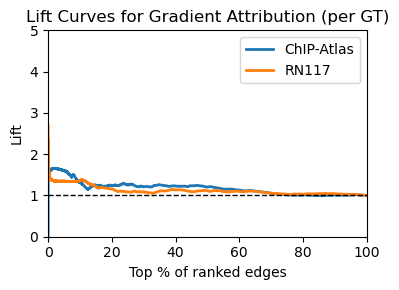

In [260]:
def lift_curve(y: np.ndarray, s: np.ndarray):
    """
    Compute lift@k for all k = 1..N.
    Returns:
        frac: fraction of predictions included
        lift: lift at each fraction
    """
    y = np.asarray(y)
    s = np.asarray(s)

    pos_rate = y.mean()
    if pos_rate == 0:
        return None, None

    order = np.argsort(s)[::-1]
    y_sorted = y[order]

    tp = np.cumsum(y_sorted)
    k = np.arange(1, len(y_sorted) + 1)

    precision = tp / k
    lift = precision / pos_rate
    frac = k / len(y_sorted)

    return frac, lift

method = "Gradient Attribution"
df = pooled_method_dict[method].copy()

fig, ax = plt.subplots(figsize=(4, 3))

for gt_name, gt_edges in ground_truth_edges_dict.items():
    d_eval = restrict_to_gt_universe(df, gt_edges)
    d_eval = d_eval.merge(gt_edges, on=["Source", "Target"], how="left")
    d_eval["_in_gt"] = d_eval["_in_gt"].fillna(0).astype(int)

    y = d_eval["_in_gt"].to_numpy()
    s = d_eval["Score"].to_numpy()

    frac, lift = lift_curve(y, s)
    if frac is None:
        continue

    ax.plot(
        frac * 100,
        lift,
        label=gt_name,
        linewidth=2,
    )

# Random baseline
ax.axhline(1.0, linestyle="--", color="black", linewidth=1)

ax.set_xlabel("Top % of ranked edges")
ax.set_ylabel("Lift")
ax.set_title(f"Lift Curves for {method} (per GT)")
ax.set_xlim(0, 100)   # focus on early enrichment (adjust as needed)
ax.set_ylim(bottom=0, top=5)

ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
def lift_curve_single_tf(y: np.ndarray, s: np.ndarray):
    """
    Lift curve for a single TF.
    y: binary labels for this TF's TGs
    s: scores for this TF's TGs
    """
    pos_rate = y.mean()
    if pos_rate == 0 or pos_rate == 1:
        return None, None

    order = np.argsort(s)[::-1]
    y_sorted = y[order]

    tp = np.cumsum(y_sorted)
    k = np.arange(1, len(y_sorted) + 1)

    precision = tp / k
    lift = precision / pos_rate
    frac = k / len(y_sorted)

    return frac, lift

def per_tf_lift_curve(
    df,                     # columns: Source, Target, Score, _in_gt
    n_points=200,
    agg="median",           # "median" or "mean"
):
    """
    Returns an aggregated per-TF lift curve.
    """
    grid = np.linspace(0.001, 1.0, n_points)
    all_lifts = []

    for tf, d_tf in df.groupby("Source"):
        y = d_tf["_in_gt"].to_numpy()
        s = d_tf["Score"].to_numpy()

        frac, lift = lift_curve_single_tf(y, s)
        if frac is None:
            continue

        # interpolate this TF's lift onto the common grid
        lift_interp = np.interp(grid, frac, lift)
        all_lifts.append(lift_interp)

    all_lifts = np.array(all_lifts)
    if all_lifts.size == 0:
        return None, None

    if agg == "median":
        lift_agg = np.nanmedian(all_lifts, axis=0)
    else:
        lift_agg = np.nanmean(all_lifts, axis=0)

    return grid * 100, lift_agg

df = pooled_method_dict[method].copy()
# df must already contain per-TF scores + _in_gt

fig, ax = plt.subplots(figsize=(4, 3))

for gt_name, gt_edges in ground_truth_edges_dict.items():
    d_eval = restrict_to_gt_universe(df, gt_edges)
    d_eval = d_eval.merge(gt_edges, on=["Source", "Target"], how="left")
    d_eval["_in_gt"] = d_eval["_in_gt"].fillna(0).astype(int)

    frac, lift = per_tf_lift_curve(d_eval, agg="median")
    if frac is None:
        continue

    ax.plot(
        frac,
        lift,
        label=gt_name,
        linewidth=2,
    )

ax.axhline(1.0, linestyle="--", color="black", linewidth=1)

ax.set_xlabel("Top % of TGs per TF")
ax.set_ylabel("Median per-TF lift")
ax.set_title(f"Per-TF Lift Curves ({method})")
ax.set_xlim(0, 100)
ax.set_ylim(bottom=0, top=5)

ax.legend()
plt.tight_layout()
plt.show()


### Precision Lift Between GRN Methods

In [262]:
percentages = [0.10, 0.50, 1.00, 5.00, 10.00, 20.00, 50.00, 70.00, 90.00]
lift_metric = "mean"
lift_cols = [f"{lift_metric}_lift@{p:.2f}%" for p in percentages]

mean_lift_by_k = merged.groupby("method")[lift_cols].mean()
mean_lift_by_k["avg_lift"] = mean_lift_by_k.mean(axis=1)
mean_lift_by_k = mean_lift_by_k.sort_values(by="avg_lift", ascending=False)
mean_lift_by_k

,mean_lift@0.10%,mean_lift@0.50%,mean_lift@1.00%,mean_lift@5.00%,mean_lift@10.00%,mean_lift@20.00%,mean_lift@50.00%,mean_lift@70.00%,mean_lift@90.00%,avg_lift
method,,,,,,,,,,
LINGER,2.164000,1.756577,1.625286,1.368399,1.298711,1.229972,1.103243,1.064646,1.024658,1.403944
Gradient Attribution,1.953952,1.810460,1.716300,1.506484,1.293956,1.116117,1.049283,1.039535,1.012756,1.388760
TF Knockout,1.583188,1.454147,1.299438,1.262088,1.230575,1.211679,1.078736,1.035312,1.007218,1.240265
Pando,1.366494,1.280602,1.319819,1.234075,1.153329,1.079012,1.011687,0.983744,0.981427,1.156688
CellOracle,1.605461,1.125930,1.117708,1.085661,1.074267,1.034705,1.009908,0.994011,0.994703,1.115817
TRIPOD,1.382142,1.227623,1.160717,1.067436,1.064248,1.059494,1.030486,1.020665,1.008090,1.113433
GRaNIE,1.063009,1.061264,1.140741,1.198702,1.169293,1.120101,1.051016,1.025478,1.005585,1.092799
FigR,0.957000,1.080827,1.077518,1.043495,1.049148,1.022017,1.018284,1.009872,1.000328,1.028721
SCENIC+,0.678517,0.912342,0.913166,0.906536,0.985172,0.964189,0.914213,0.937712,0.972595,0.909382


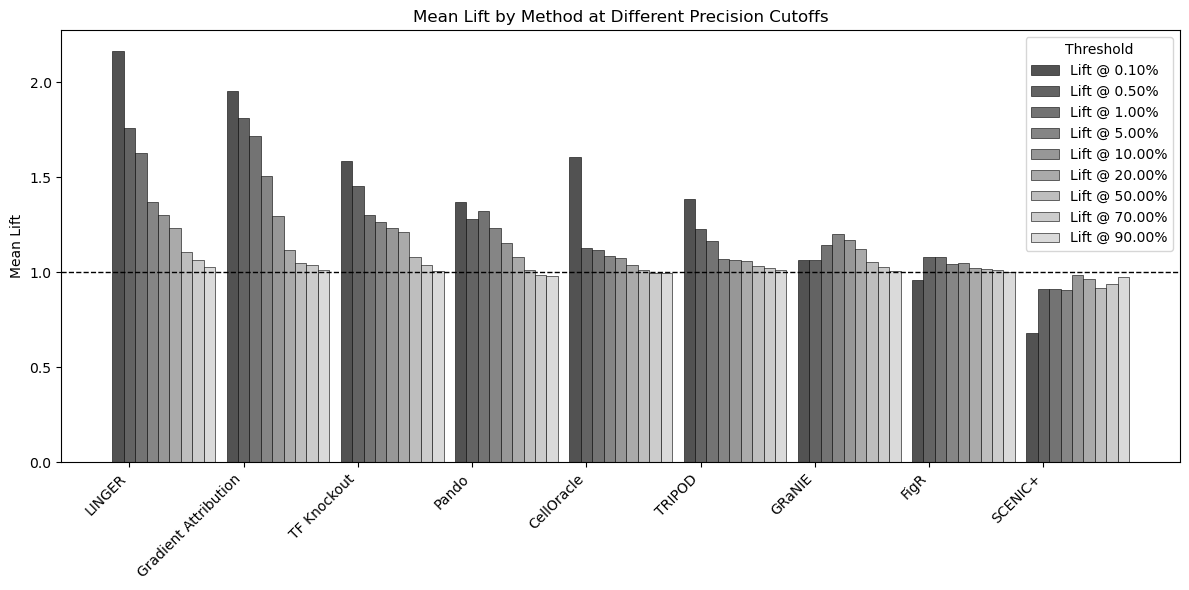

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

df_plot = mean_lift_by_k[lift_cols]
order = mean_lift_by_k["avg_lift"].sort_values(ascending=False).index.tolist()
df_plot = df_plot.reindex(order)

methods = df_plot.index.tolist()
x = np.arange(len(methods))
width = 0.1

# --- define grayscale levels per threshold ---
# darker → lighter as threshold increases
cmap = cm.Greys_r
shades = cmap(np.linspace(0.25, 0.75, len(lift_cols)))  
# adjust bounds if you want more contrast

fig, ax = plt.subplots(figsize=(12, 6))

for i, (col, color) in enumerate(zip(lift_cols, shades)):
    ax.bar(
        x + (i - 1) * width,
        df_plot[col].values,
        width,
        color=color,
        edgecolor="black",
        linewidth=0.4,
        label=col.replace(f"{lift_metric}_lift@", "Lift @ ")
    )

ax.axhline(1.0, linestyle="--", linewidth=1, color="black")

ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha="right")
ax.set_ylabel(f"{lift_metric.capitalize()} Lift")
ax.set_title(f"{lift_metric.capitalize()} Lift by Method at Different Precision Cutoffs")

ax.legend(title="Threshold")
plt.tight_layout()
plt.show()


In [227]:
(
    merged.groupby("method")["median_lift@0.10%"]
    .mean()
    .sort_values(ascending=False)
)


method
Gradient Attribution    1.808626
LINGER                  1.381462
TRIPOD                  1.087202
GRaNIE                  1.043929
CellOracle              0.846446
FigR                    0.805988
Pando                   0.591942
TF Knockout             0.577693
SCENIC+                 0.000000
Name: median_lift@0.10%, dtype: float64

### AUROC Boxplots

In [228]:
def plot_pooled_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("method")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["method"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["method"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.0, 1.0))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.0, 1.0))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

def plot_all_results_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("name")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["name"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

In [233]:
auroc_testing_per_tf_df = pd.read_csv(EXPERIMENT_DIR / "per_tf_auroc_auprc_detailed.csv")
auroc_testing_per_tf_df = auroc_testing_per_tf_df[["method", "gt_name", "tf", "auroc", "auprc"]].rename(columns={"gt_name": "gt"})
auroc_testing_per_tf_df.head()

,method,gt,tf,auroc,auprc
0,CellOracle,ChIP-Atlas,ARID2,0.526867,0.516775
1,CellOracle,ChIP-Atlas,ARID3A,0.528740,0.536741
2,CellOracle,ChIP-Atlas,ARNT,0.502515,0.511833
3,CellOracle,ChIP-Atlas,ATF1,0.498860,0.497599
4,CellOracle,ChIP-Atlas,ATF2,0.475089,0.501581


In [230]:
df = per_tf_all_df.copy()
merged = df.merge(
    auroc_testing_per_tf_df,
    on=["method", "gt", "tf"],
    suffixes=("_dev", "_tf_testing"),
    how="inner"
)
df = merged[["method", "gt", "tf", "auroc_dev", "auroc_tf_testing"]]
df["difference"] = df["auroc_dev"] - df["auroc_tf_testing"]
df = df[df["method"] == "Gradient Attribution"]
df

/tmp/ipykernel_3917534/4138363068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["difference"] = df["auroc_dev"] - df["auroc_tf_testing"]


,method,gt,tf,auroc_dev,auroc_tf_testing,difference
1533,Gradient Attribution,ChIP-Atlas,ATF3,0.530080,0.530080,0.0
1534,Gradient Attribution,ChIP-Atlas,BACH1,0.532997,0.532997,0.0
1535,Gradient Attribution,ChIP-Atlas,BCL6,0.521545,0.521545,0.0
1536,Gradient Attribution,ChIP-Atlas,CEBPG,0.524374,0.524374,0.0
1537,Gradient Attribution,ChIP-Atlas,CGGBP1,0.524583,0.524583,0.0
...,...,...,...,...,...,...
1648,Gradient Attribution,RN117,ZNF197,0.550656,0.550656,0.0
1649,Gradient Attribution,RN117,ZNF263,0.525312,0.525312,0.0
1650,Gradient Attribution,RN117,ZNF280A,0.534693,0.534693,0.0
1651,Gradient Attribution,RN117,ZNF407,0.527547,0.527547,0.0


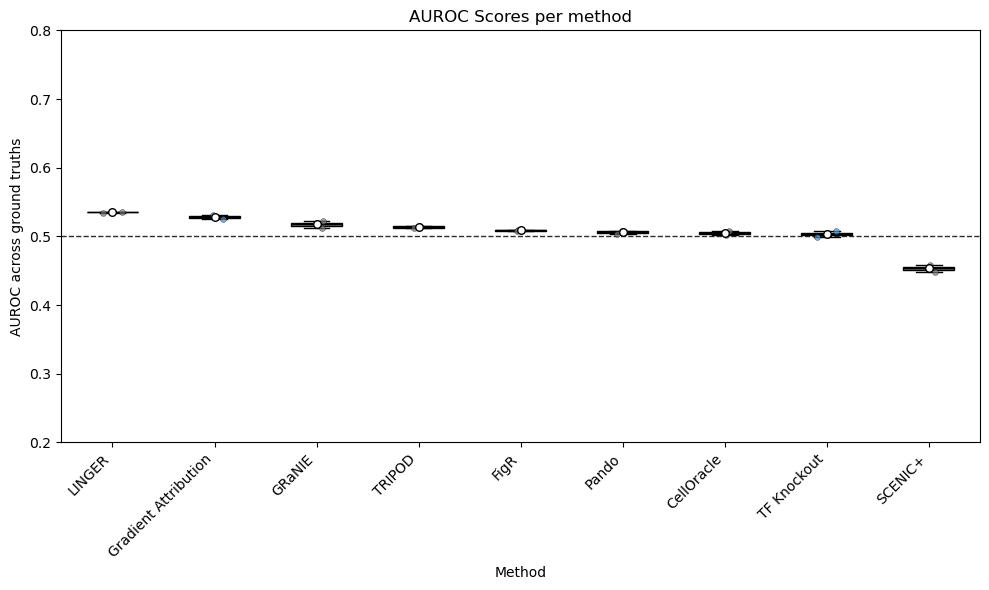

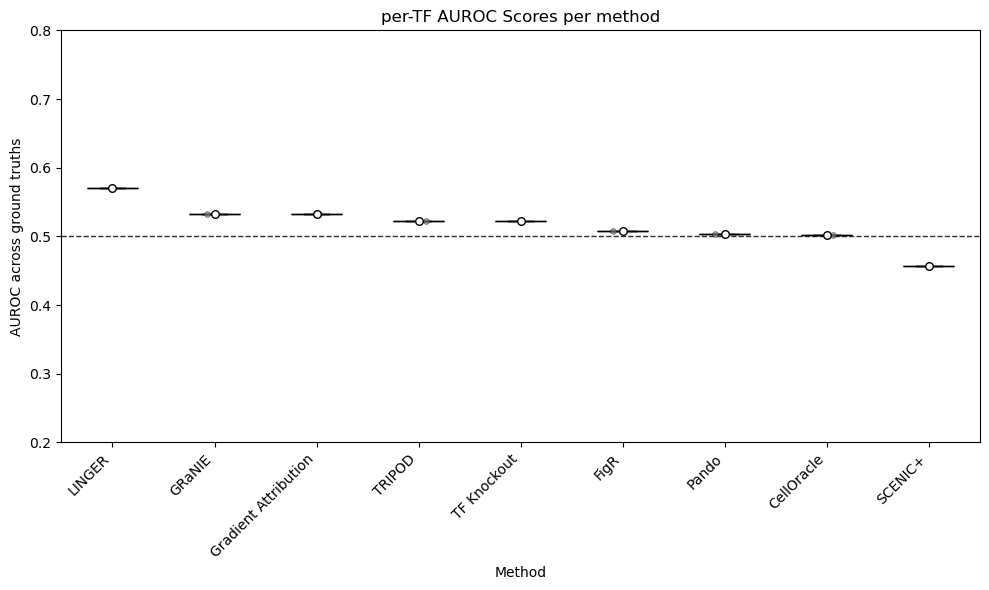

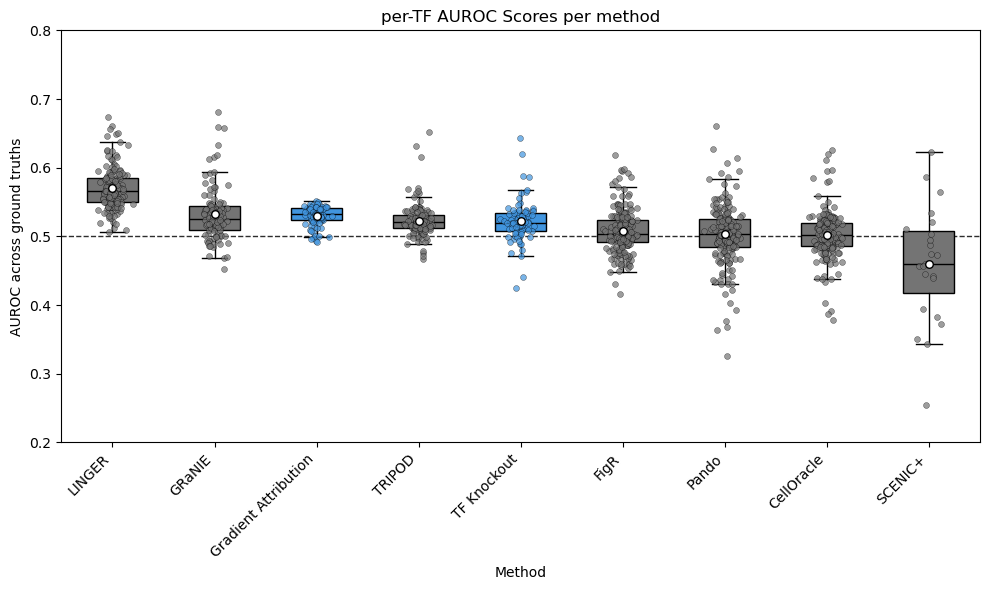

In [ ]:
results_df = pd.DataFrame(all_results)
results_df.groupby("method")["auroc"].mean().sort_values(ascending=False)
results_df["name"] = results_df["method"]
plot_all_results_auroc_boxplot(results_df, per_tf=False)
plt.show()

df = per_tf_all_df.copy()

per_tf_mean_across_gt = (
    df
    .dropna(subset=["auroc"])
    .groupby(["method", "gt"], as_index=False)
    .agg(
        auroc=("auroc", "mean"),
        n_gt=("gt", "nunique"),
    )
)

# ===== Method 3: Calculate the Mean TF AUROC/AUPRC Across All GTs =====
per_tf_grouped = (
    df.dropna(subset=["auroc"])
    .groupby(['method', 'tf'], as_index=False)
    .agg(
        auroc=('auroc', 'mean'),
        n_gt=('gt', 'nunique'),
    )
)
per_tf_grouped["name"] = per_tf_grouped["method"]
per_tf_mean_across_gt["name"] = per_tf_mean_across_gt["method"]


#Plot the boxplots and save data like above methods
per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True)

fig_per_tf = plot_all_results_auroc_boxplot(
    per_tf_grouped,
    per_tf=True
)
plt.show()


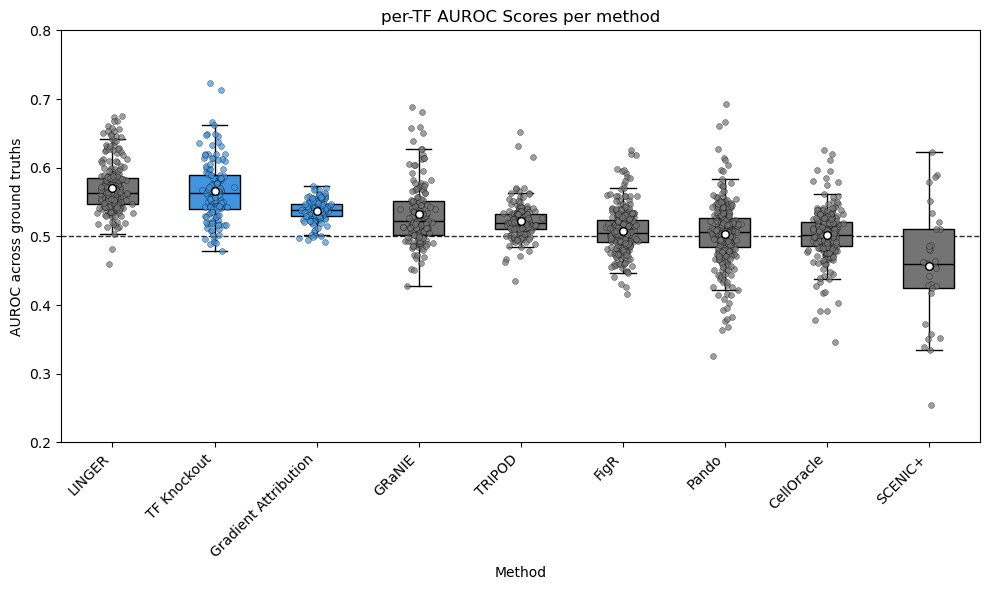

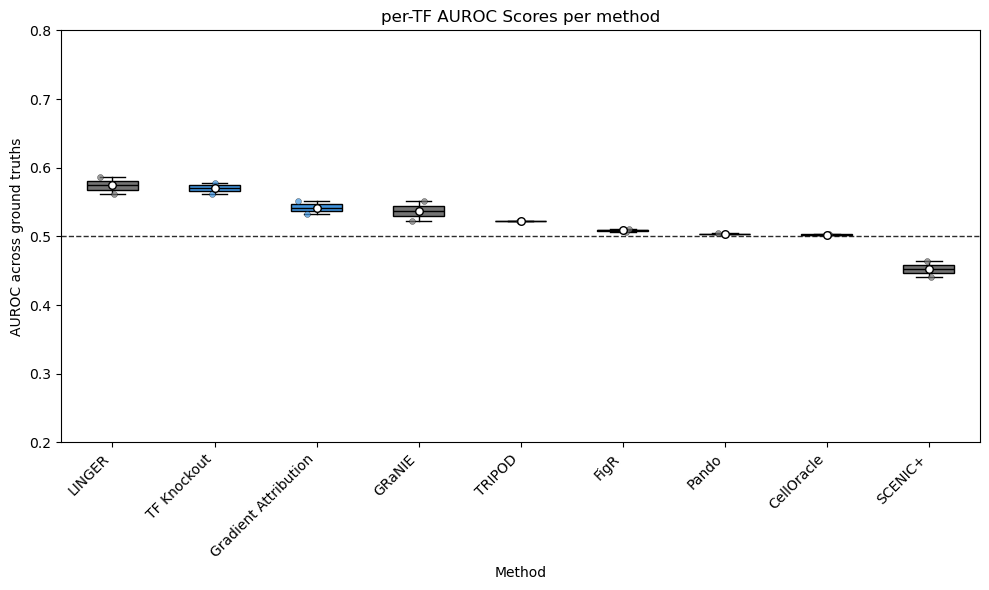

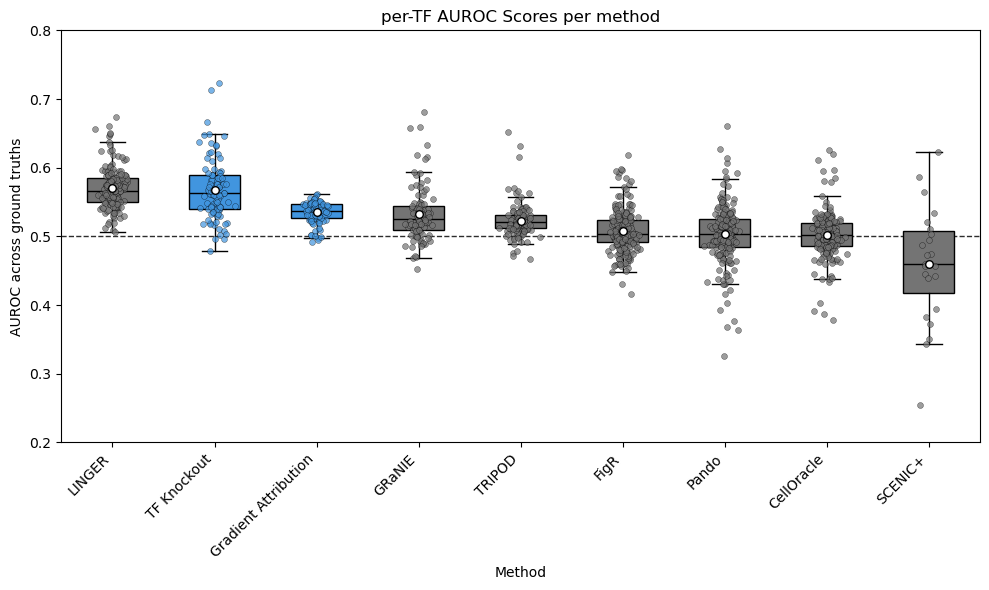

In [ ]:
selected_dir = "K562_hvg_filter_disp_0.01"
DATA_DIR = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments"
SELECTED_EXP_DIR = Path(DATA_DIR) / f"{selected_dir}/chr19/model_training_001/"

df = pd.read_csv(SELECTED_EXP_DIR / "per_tf_auroc_auprc_detailed.csv")
df = df.rename(columns={"gt_name": "gt"})
df["name"] = df["method"]

per_tf_mean_df = (
    df
    .groupby(["name", "tf"], as_index=False)["auroc"]
    .mean()
)

plot_all_results_auroc_boxplot(df, per_tf=True)

per_tf_mean_across_gt = (
    df
    .dropna(subset=["auroc"])
    .groupby(["method", "gt"], as_index=False)
    .agg(
        auroc=("auroc", "mean"),
        n_gt=("gt", "nunique"),
    )
)

# ===== Method 3: Calculate the Mean TF AUROC/AUPRC Across All GTs =====
per_tf_grouped = (
    df.dropna(subset=["auroc"])
    .groupby(['method', 'tf'], as_index=False)
    .agg(
        auroc=('auroc', 'mean'),
        n_gt=('gt', 'nunique'),
    )
)
per_tf_grouped["name"] = per_tf_grouped["method"]
per_tf_mean_across_gt["name"] = per_tf_mean_across_gt["method"]


#Plot the boxplots and save data like above methods
per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True)

fig_per_tf = plot_all_results_auroc_boxplot(
    per_tf_grouped,
    per_tf=True
)
plt.show()
